In [1]:
import numpy as np
import os
import glob
import cv2
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Dropout, Dense, concatenate, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
from keras.callbacks import TensorBoard
import keras.backend as K

In [4]:
import keras

In [5]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [7]:
tensorboard_cback = TensorBoard()

In [6]:
#ab1 = np.load('data/ab/ab/ab1.npy')
#ab2 = np.load('data/ab/ab/ab2.npy')
#ab3 = np.load('data/ab/ab/ab3.npy')
#gray_scale = np.load('data/l/gray_scale.npy').astype(np.float16)
#gray_scale = gray_scale/255.0
#np.save('processed_gray.npy', gray_scale)

In [8]:
gray_scale = np.load('processed_gray.npy')

In [9]:
def get_rgb_from_lab(gray, ab_imgs, batch_size):
    imgs = np.zeros((batch_size, 224, 224, 3))
    imgs[:,:,:,0] = gray[0:batch_size:]
    imgs[:,:,:,1:] = ab_imgs[0:batch_size:]
    imgs = imgs.astype('uint8')
    to_ret = []
    for i in range(0,batch_size):
        to_ret.append(cv2.cvtColor(imgs[i], cv2.COLOR_LAB2LRGB))
    to_ret = np.array(to_ret)
    return to_ret

In [8]:
#data = get_rgb_from_lab(gray_scale, ab1, len(ab1))
#np.save("data.npy",data)
#data = np.load("data.npy").astype(np.float16)
#data = data/255
#np.save("processed_data.npy", data)

In [10]:
data = np.load("processed_data.npy")

In [11]:
data

array([[[[0.898   , 0.816   , 0.71    ],
         [0.2118  , 0.2118  , 0.1726  ],
         [0.05884 , 0.05884 , 0.0392  ],
         ...,
         [0.011765, 0.01569 , 0.011765],
         [0.01569 , 0.01569 , 0.00784 ],
         [0.0392  , 0.04315 , 0.02745 ]],

        [[0.8433  , 0.8     , 0.6704  ],
         [0.2864  , 0.2783  , 0.2196  ],
         [0.0549  , 0.0549  , 0.04315 ],
         ...,
         [0.0196  , 0.0196  , 0.01569 ],
         [0.02353 , 0.02745 , 0.0196  ],
         [0.02353 , 0.02745 , 0.011765]],

        [[0.686   , 0.643   , 0.5215  ],
         [0.6743  , 0.655   , 0.5767  ],
         [0.1216  , 0.1177  , 0.0902  ],
         ...,
         [0.051   , 0.05884 , 0.04706 ],
         [0.02353 , 0.02745 , 0.0196  ],
         [0.0745  , 0.0706  , 0.0549  ]],

        ...,

        [[0.01569 , 0.0196  , 0.01569 ],
         [0.0196  , 0.02353 , 0.0196  ],
         [0.01569 , 0.01569 , 0.011765],
         ...,
         [0.      , 0.00392 , 0.      ],
         [0.      , 0.

In [12]:
def build_model():
    i = Input(shape = (224,224,1))
    l1 = Conv2D(64,
                kernel_size=(3,3),
                activation='relu',
               padding='same')(i)
    l1 = MaxPooling2D()(l1)
    l1 = Conv2D(128,
                kernel_size=(3,3),
                activation='relu',
               padding='same')(l1)
    l1 = MaxPooling2D()(l1)
    l1 = Conv2D(256,
                kernel_size=(3,3),
                activation='relu',
               padding='same')(l1)
    l1 = MaxPooling2D()(l1)
    l1 = Conv2D(512,
                kernel_size=(3,3),
                activation='relu',
               padding='same')(l1)
    l1 = MaxPooling2D()(l1)
    l1 = Conv2D(1024,
                kernel_size=(3,3),
                activation='relu',
               padding='same')(l1)
    l1 = UpSampling2D(size=(2,2))(l1)
    l1 = Conv2D(512,
                kernel_size=(3,3),
                activation='relu',
               padding='same')(l1)
    l1 = Conv2D(512,
                kernel_size=(3,3),
                activation='relu',
               padding='same')(l1)
    l1 = UpSampling2D(size=(2,2))(l1)
    l1 = Conv2D(256,
                kernel_size=(3,3),
                activation='relu',
               padding='same')(l1)
    l1 = Conv2D(256,
                kernel_size=(3,3),
                activation='relu',
               padding='same')(l1)
    l1 = UpSampling2D(size=(2,2))(l1)
    l1 = Conv2D(128,
                kernel_size=(3,3),
                activation='relu',
               padding='same')(l1)
    l1 = Conv2D(128,
                kernel_size=(3,3),
                activation='relu',
               padding='same')(l1)
    l1 = UpSampling2D()(l1)
    outs = Conv2D(3,
                kernel_size=(3,3),
                activation='relu',
               padding='same')(l1)
    model = Model(inputs=[i], outputs=[outs])
    model.compile(optimizer='rmsprop', loss='mse')
    return model

In [13]:
model = build_model()

In [14]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 256)       0   

In [15]:
gray_b1 = gray_scale[:10000]

In [16]:
gray_b1 = np.expand_dims(gray_b1, 3)

In [17]:
data.shape, gray_b1.shape

((10000, 224, 224, 3), (10000, 224, 224, 1))

In [18]:
model.fit(gray_b1, data, batch_size=16, epochs = 20, verbose=1,
          callbacks=[tensorboard_cback])

Epoch 1/20
   32/10000 [..............................] - ETA: 1:32:02 - loss: 223241280.0479

/home/dexter/anaconda3/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (2.257898). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


   48/10000 [..............................] - ETA: 1:11:47 - loss: 148827520.0635

/home/dexter/anaconda3/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (1.896887). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


   64/10000 [..............................] - ETA: 54:28 - loss: 111620640.0699  

/home/dexter/anaconda3/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.949104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


10000/10000 [==============================] - 196s 20ms/step - loss: 714372.3676
Epoch 2/20
10000/10000 [==============================] - 172s 17ms/step - loss: 0.0555
Epoch 3/20
10000/10000 [==============================] - 169s 17ms/step - loss: 0.0213
Epoch 4/20
10000/10000 [==============================] - 173s 17ms/step - loss: 0.0173
Epoch 5/20
10000/10000 [==============================] - 170s 17ms/step - loss: 0.0153
Epoch 6/20
10000/10000 [==============================] - 174s 17ms/step - loss: 0.0142
Epoch 7/20
 3200/10000 [========>.....................] - ETA: 1:58 - loss: 0.0136

KeyboardInterrupt: 

In [26]:
ans = model.predict(np.expand_dims(gray_b1[0], 0))

In [36]:
gray_b1[0,:,:,0]

array([[0.929  , 0.5293 , 0.2942 , ..., 0.1372 , 0.1451 , 0.2471 ],
       [0.9175 , 0.596  , 0.2825 , ..., 0.1608 , 0.1921 , 0.1843 ],
       [0.8433 , 0.847  , 0.408  , ..., 0.2864 , 0.1882 , 0.3215 ],
       ...,
       [0.1569 , 0.1765 , 0.149  , ..., 0.04315, 0.03137, 0.03137],
       [0.1569 , 0.2196 , 0.1843 , ..., 0.03137, 0.02745, 0.0392 ],
       [0.1647 , 0.2354 , 0.3098 , ..., 0.04706, 0.051  , 0.05884]],
      dtype=float16)

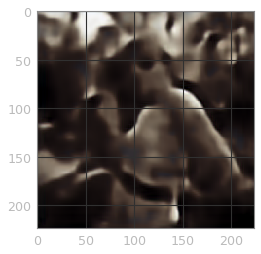

In [47]:
plt.imshow(ans[0,:,:,:])

In [37]:
ans[0,:,:,:]

array([[[0.46394527, 0.43701336, 0.46001887],
        [0.5708305 , 0.5609522 , 0.5462243 ],
        [0.5809494 , 0.5727252 , 0.55636907],
        ...,
        [0.34887797, 0.32404137, 0.31122375],
        [0.37124538, 0.33600593, 0.33228526],
        [0.34408602, 0.30537212, 0.2692897 ]],

       [[0.5039085 , 0.4868411 , 0.49049112],
        [0.6249736 , 0.61158574, 0.60431534],
        [0.6371037 , 0.6219909 , 0.6133735 ],
        ...,
        [0.34887472, 0.32034457, 0.29814896],
        [0.3704257 , 0.33935946, 0.32105717],
        [0.36149785, 0.33831915, 0.29286584]],

       [[0.4909627 , 0.45352545, 0.45503554],
        [0.5909103 , 0.57157564, 0.5498252 ],
        [0.5996424 , 0.5758941 , 0.55423784],
        ...,
        [0.35853678, 0.32316506, 0.2969632 ],
        [0.37654096, 0.33849308, 0.3192731 ],
        [0.36213145, 0.33546206, 0.30382612]],

       ...,

       [[0.00528222, 0.        , 0.01253966],
        [0.00965357, 0.00639798, 0.00620324],
        [0.0310079 , 0

In [42]:
gray_b1[0,:,:,0].shape

(224, 224)

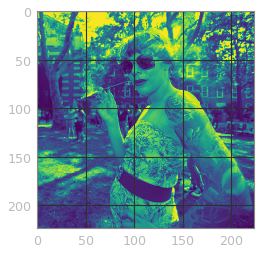

In [46]:
plt.imshow(gray_b1[0,:,:,0].astype(np.float32))